In [17]:
#@ Downloading necessary data:
import os
if not os.path.exists('dataset1'):
  !wget -q https://www.dropbox.com/s/0pigmmmynbf9xwq/dataset1.zip
  !unzip -q dataset1.zip
  !rm dataset1.zip
  !pip install -q torch_snippets pytorch_model_summary

In [18]:
#@ Importing necessaries dependencies:
import torch
from torch_snippets import *
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch import nn
device ='cuda' if torch.cuda.is_available() else 'cpu'
from torch.utils.data import Dataset, DataLoader
import cv2
from torch import optim

In [19]:
#@ function for image transformation:
tfms=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]) # accord to imagenet dataset
])

In [32]:
#@ Fetching input and output images for training:
class SegData(Dataset):
  def __init__(self, split):
    self.items=stems(f'dataset1/images_prepped_{split}')
    self.split=split

  def __len__(self):
    return len(self.items)

  def __getitem__(self, ix):
    image=read(f'dataset1/images_prepped_{self.split}/{self.items[ix]}.png', 1)
    image = cv2.resize(image, (224, 224))
    mask = read(f'dataset1/annotations_prepped_{self.split}/{self.items[ix]}.png', 0)
    mask = cv2.resize(mask, (224,224))
    return image, mask

  # random image index for debugging purpose:
  def choose(self):
    return self[randint(len(self))]

  def collate_fn(self, batch):
     # Filter out None values from the batch
        batch = [item for item in batch if item is not None]

        # If the batch is now empty, handle it appropriately
        if not batch:
            print("Warning: Batch is empty after filtering None values. Returning empty tensors.")
            return torch.empty((0)), torch.empty((0)) # Or handle it differently as needed

        ims, masks=list(zip(*batch))
        ims=torch.cat([tfms(im.copy()/255.)[None] for im in ims]).float().to(device)
        ce_mask=torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(device)
        return ims, ce_mask

In [33]:
#@ training and valid dataset:
train_ds=SegData('train')
valid_ds=SegData('test')
trn_dl=DataLoader(train_ds, batch_size=4, shuffle=True, collate_fn=train_ds.collate_fn)
val_dl=DataLoader(valid_ds, batch_size=1, shuffle=True, collate_fn=valid_ds.collate_fn)


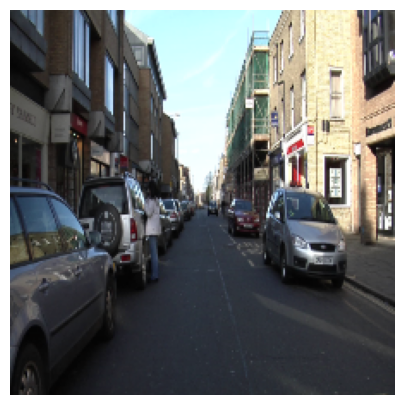

In [34]:
show(train_ds[10][0])

##### Architecture for image segmentation

In [35]:
#@ defining convolution blocks:
def conv(in_channels, out_channels):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True)
  )

In [36]:
#@ defining Up-Convolution:
def up_conv(in_channels, out_channels):
  return nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2), # ensure image upscaling
      nn.ReLU(inplace=True)
  )

In [44]:
#@ Defining Network Class:
from torchvision.models import vgg16_bn # for large scale
class UNet(nn.Module):
  def __init__(self, pretrained=True, out_channels=12):
    super().__init__()
    self.encoder=vgg16_bn(pretrained=pretrained).features # excluding FC at end

    # encoder blocks
    self.block1=nn.Sequential(*self.encoder[:6])
    self.block2=nn.Sequential(*self.encoder[6:13])
    self.block3=nn.Sequential(*self.encoder[13:20])
    self.block4=nn.Sequential(*self.encoder[20:27])
    self.block5=nn.Sequential(*self.encoder[27:34])

    self.bottleneck=nn.Sequential(*self.encoder[34:]) #acts between encoder and decoder
    self.conv_bottleneck=conv(512, 1024)

    self.up_conv6=up_conv(1024, 512)
    self.conv6=conv(512 + 512, 512)
    self.up_conv7=up_conv(512, 256)
    self.conv7=conv(256 + 512, 256)
    self.up_conv8=up_conv(256, 128)
    self.conv8=conv(128 + 256, 128)
    self.up_conv9=up_conv(128, 64)
    self.conv9=conv(64+128, 64)
    self.up_conv10=up_conv(64, 32)
    self.conv10=conv(32 + 64, 32)

    self.conv11=nn.Conv2d(32, out_channels, kernel_size=1)

  def forward(self, x):
    block1=self.block1(x)
    block2=self.block2(block1)
    block3=self.block3(block2)
    block4=self.block4(block3)
    block5=self.block5(block4)

    bottleneck=self.bottleneck(block5)
    x=self.conv_bottleneck(bottleneck)

    x=self.up_conv6(x)
    x=torch.cat([x, block5], dim=1)
    x=self.conv6(x)

    x=self.up_conv7(x)
    x=torch.cat([x, block4], dim=1)
    x=self.conv7(x)

    x=self.up_conv8(x)
    x=torch.cat([x, block3], dim=1)
    x=self.conv8(x)

    x=self.up_conv9(x)
    x=torch.cat([x, block2], dim=1)
    x=self.conv9(x)


    x=self.up_conv10(x)
    x=torch.cat([x, block1], dim=1)
    x=self.conv10(x)

    x=self.conv11(x)

    return x


In [51]:
#@ Loss function:
ce=nn.CrossEntropyLoss()
def UnetLoss(preds, targets):
  ce_loss=ce(preds, targets)
  acc=(torch.max(preds, 1)[1]==targets).float().mean()
  return ce_loss, acc

In [52]:
#@ batch training:
def train_batch(model, data, optimizer, criterion):
  model.train()
  ims, ce_masks=data
  _masks=model(ims)
  optimizer.zero_grad()
  loss, acc=criterion(_masks, ce_masks)
  loss.backward()
  optimizer.step()
  return loss.item(), acc.item()

In [53]:
#@ validation:

@torch.no_grad()
def valid_batch(model, data, criterion):
  model.eval()
  ims, masks=data
  _masks=model(ims)
  loss, acc=criterion(_masks, masks)
  return loss.item(), acc.item()


In [54]:
model=UNet().to(device)
criterion=UnetLoss
optimizer=optim.Adam(model.parameters(), lr=1e-3)
n_epochs=20

In [55]:
from torch_snippets.torch_loader import Report
import time
import numpy

In [56]:
#@ training model over increasing epochs:
log=Report(n_epochs)
for ex in range(n_epochs):
  N=len(trn_dl)
  for bx, data in enumerate(trn_dl):
    loss, acc=train_batch(model, data, optimizer, criterion)
    log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

  N=len(val_dl)
  for bx, data in enumerate(val_dl):
    loss, acc=valid_batch(model, data, criterion)
    log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')

  log.report_avgs(ex+1)

EPOCH: 1.000  trn_loss: 1.150  val_acc: 0.814  trn_acc: 0.726  val_loss: 0.788  (18.72s - 355.71s remaining)
EPOCH: 2.000  trn_loss: 0.678  val_acc: 0.842  trn_acc: 0.828  val_loss: 0.641  (37.53s - 337.79s remaining)
EPOCH: 3.000  trn_loss: 0.568  val_acc: 0.820  trn_acc: 0.845  val_loss: 0.664  (56.02s - 317.43s remaining)
EPOCH: 4.000  trn_loss: 0.532  val_acc: 0.861  trn_acc: 0.852  val_loss: 0.526  (74.73s - 298.92s remaining)
EPOCH: 5.000  trn_loss: 0.466  val_acc: 0.877  trn_acc: 0.871  val_loss: 0.452  (92.89s - 278.66s remaining)
EPOCH: 6.000  trn_loss: 0.441  val_acc: 0.851  trn_acc: 0.875  val_loss: 0.551  (111.54s - 260.27s remaining)
EPOCH: 7.000  trn_loss: 0.461  val_acc: 0.867  trn_acc: 0.868  val_loss: 0.426  (129.97s - 241.38s remaining)
EPOCH: 8.000  trn_loss: 0.404  val_acc: 0.871  trn_acc: 0.884  val_loss: 0.435  (148.30s - 222.46s remaining)
EPOCH: 9.000  trn_loss: 0.380  val_acc: 0.847  trn_acc: 0.892  val_loss: 0.503  (166.79s - 203.86s remaining)
EPOCH: 10.000  

100%|██████████| 121/121 [00:00<00:00, 1515.80it/s]


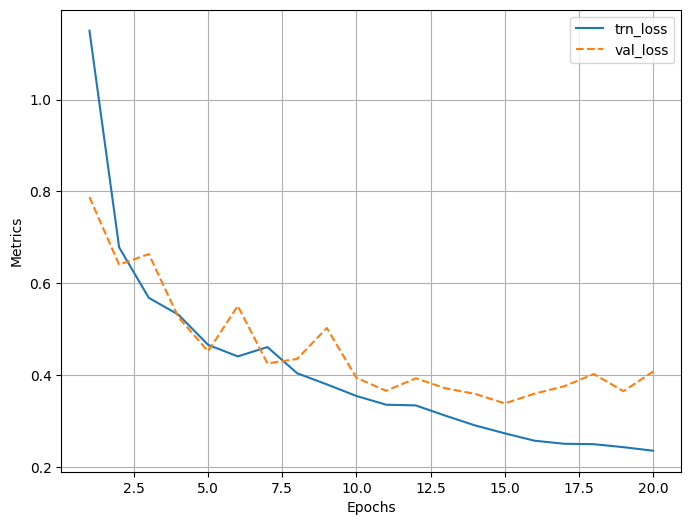

In [57]:
log.plot_epochs(['trn_loss','val_loss'])

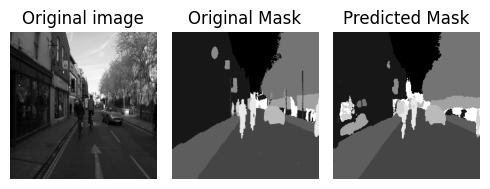

In [58]:
im , mask=next(iter(val_dl))
_mask=model(im)
_, _mask=torch.max(_mask, dim=1)
subplots([im[0].permute(1, 2, 0).detach().cpu()[:, :, 0], mask.permute(1, 2, 0).detach().cpu()[:, :, 0],
          _mask.permute(1, 2, 0).detach().cpu()[:, :, 0]],
         nc=3, titles=['Original image', 'Original Mask', 'Predicted Mask'])